In [ ]:
 # Imported Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# **1. Préparation des données**

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [ ]:
df.isnull().sum().max()

0

In [ ]:
from sklearn.preprocessing import StandardScaler
# Normalisation des colonnes Time et Amount
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

In [ ]:
# Séparation features/target
X = df.drop('Class', axis=1)
y = df['Class']

# **2. Split stratifié + SMOTE**

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# SMOTE pour sur-échantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# **3. Models**

## **3.1. Machine Learning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)


RandomForestClassifier(random_state=42)

In [ ]:
import joblib

joblib.dump(rf_model, 'rf_model.pkl')


['rf_model.pkl']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # pour AUC-ROC

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))


[[56849    15]
 [   16    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.973103297664029


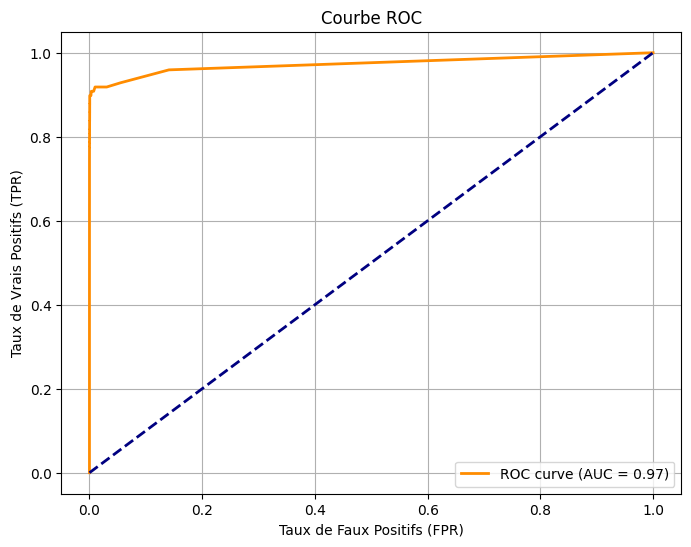

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()


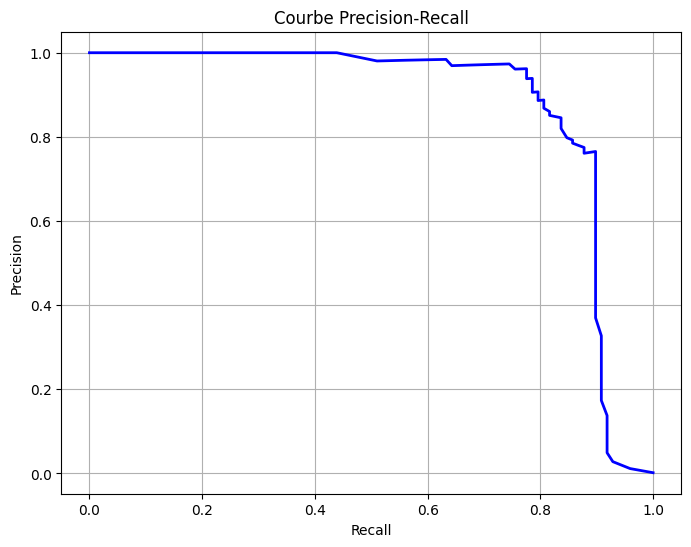

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall')
plt.grid()
plt.show()


## **3.2. Deep Learning**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Reprise des données déjà normalisées
X = df.drop('Class', axis=1)
y = df['Class']

# Séparation train/test stratifiée
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# On ne garde que les transactions normales pour l’entraînement
X_train_normal = X_train[y_train == 0]


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

input_dim = X_train_normal.shape[1]
input_layer = Input(shape=(input_dim,))

# Architecture simple
encoded = Dense(14, activation='relu',
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=20,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

Epoch 1/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.9618 - val_loss: 0.8401
Epoch 2/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.8398 - val_loss: 0.8292
Epoch 3/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.8337 - val_loss: 0.8214
Epoch 4/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.8118 - val_loss: 0.8199
Epoch 5/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.8415 - val_loss: 0.8131
Epoch 6/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.8422 - val_loss: 0.8111
Epoch 7/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8089 - val_loss: 0.8100
Epoch 8/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.8119 - val_loss: 0.8092
Epoch 9/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8486 - val_loss: 0.8080
Epoch 10/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.8315 - val_loss: 0.8064
Epoch 11/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.8165 - val_loss: 0.8063
Epoch 12/20
5687/56

In [ ]:
# Prédictions sur le test set
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=1)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, reconstruction_error))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.86      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962

AUC-ROC: 0.9547183110723185
